<a href="https://colab.research.google.com/github/Chubbyman2/Gesture_Classifier/blob/main/Gesture_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import keras
import matplotlib.style as style
import numpy as np
from keras import optimizers, models, layers
from keras.callbacks import Callback
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/My Drive/gestures_data.zip"

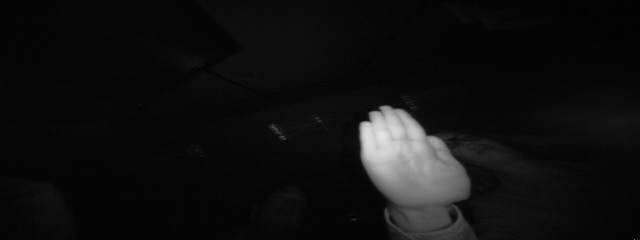

In [4]:
# Image sample from dataset
from IPython.display import Image

img = Image("gestures_data/00/01_palm/frame_00_01_0001.png")
img

In [5]:
# Create a dictionary of the classes and a reverse dictionary
classes = dict()
reverse_classes = dict()
count = 0
for img in os.listdir('gestures_data/00'):
    if not img.startswith('.'):
        classes[img] = count
        reverse_classes[count] = img
        count = count + 1

classes

{'01_palm': 3,
 '02_l': 6,
 '03_fist': 9,
 '04_fist_moved': 1,
 '05_thumb': 2,
 '06_index': 7,
 '07_ok': 0,
 '08_palm_moved': 5,
 '09_c': 8,
 '10_down': 4}

In [10]:
from PIL import Image

def get_data(start, stop):
    x_data = []
    y_data = []

    # Total number of images in dataset
    datacount = 0 
    for i in range(start, stop): # Loop over ten top-level folders
        for j in os.listdir(f"gestures_data/0{str(i)}/"):
            if not j.startswith('.'): # Avoid hidden folders
                count = 0 # Number of images of a given gesture
                for k in os.listdir(f"gestures_data/0{str(i)}/{j}/"):
                    try:
                      # Loop over the images, convert to greyscale
                      img = Image.open(f"gestures_data/0{str(i)}/{j}/{k}").convert('L')
                      img = img.resize((224, 224))
                      arr = np.array(img)
                      x_data.append(arr) 
                      count = count + 1
                    except:
                      pass
                y_values = np.full((count, 1), classes[j]) 
                y_data.append(y_values)
                datacount = datacount + count
                
    return x_data, y_data

In [11]:
# Normalizes data, converts to numpy arrays
def process_data(x_data, y_data):
    x_data = np.array(x_data, dtype = "float32")
    x_data = x_data.reshape((len(x_data), 224, 224, 1))
    x_data /= 255
    
    y_data = np.array(y_data)
    y_data = y_data.reshape(len(x_data), 1)
    y_data = to_categorical(y_data)
    return x_data, y_data

In [12]:
# Use first 8 folders of data for training
X_train, y_train = get_data(0, 8)
X_train, y_train = process_data(X_train, y_train)

# Use last 2 folders of data for testing
X_test, y_test = get_data(8, 10)
X_test, y_test = process_data(X_test, y_test)

In [13]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [24]:
# Model, input is 224x224 grayscale images
model = models.Sequential([
    Conv2D(32, (5, 5), strides=(2, 2), activation="relu", input_shape=(224, 224, 1)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax") 
])

In [27]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.fit(datagen.flow(X_train, y_train, batch_size=128), steps_per_epoch = len(X_train)/128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
125/125 [==============================] - 56s 448ms/step - loss: 1.5952 - accuracy: 0.4519 - val_loss: 1.8194 - val_accuracy: 0.5410
Epoch 2/10
125/125 [==============================] - 55s 443ms/step - loss: 0.5540 - accuracy: 0.8133 - val_loss: 1.4174 - val_accuracy: 0.6015
Epoch 3/10
125/125 [==============================] - 54s 435ms/step - loss: 0.2974 - accuracy: 0.9032 - val_loss: 1.3449 - val_accuracy: 0.5615
Epoch 4/10
125/125 [==============================] - 54s 429ms/step - loss: 0.1871 - accuracy: 0.9384 - val_loss: 1.1451 - val_accuracy: 0.7240
Epoch 5/10
125/125 [==============================] - 53s 424ms/step - loss: 0.1364 - accuracy: 0.9578 - val_loss: 1.0995 - val_accuracy: 0.6990
Epoch 6/10
125/125 [==============================] - 54s 429ms/step - loss: 0.1181 - accuracy: 0.9651 - val_loss: 1.1359 - val_accuracy: 0.6670
Epoch 7/10
125/125 [==============================] - 53s 426ms/step - loss: 0.0766 - accuracy: 0.9769 - val_loss: 0.8753 - val_ac

In [29]:
model.save("gesture_classifier.h5")